## Imports

In [1]:
import pandas as pd
from collections import Counter
import seaborn as sns
import numpy 

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,f1_score
from sklearn.linear_model import LogisticRegression
from sys import getsizeof

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [3]:
scorer = make_scorer(f1_score, needs_proba=False,
                     greater_is_better=True,average='micro')

## Data import

In [4]:
df = pd.read_csv('../input/train_values.csv')
train_target = pd.read_csv('../input/train_labels.csv')

In [5]:
Counter(train_target.damage_grade)

Counter({3: 87218, 2: 148259, 1: 25124})

In [9]:

y = train_target.damage_grade

## Utils

In [174]:
def give_sub_file(preds, ids, path='../output/preds.csv'):
    preds = pd.DataFrame(preds,columns=['damage_grade'])
    preds['building_id'] = ids
    preds = preds[['building_id', 'damage_grade']]
    print(preds.columns)
    print(preds.shape)
    preds.to_csv(path, index=False)


In [ ]:
# preds = estimator.predict(X_test)
# give_sub_file(preds, X_test.building_id.tolist())

## Class distribution

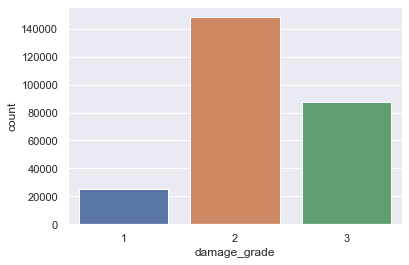

In [11]:
sns.set(style="darkgrid")

ax = sns.countplot(x="damage_grade", data=train_target)

In [15]:
# Metric to be used
# F1 score with argument micro has to be used

In [16]:
from sklearn.metrics import f1_score

f1_score(y_true= , y_pred = average='micro')

## Base line model always predict mode ( class = 2 ) 

In [18]:
# lets see our f1 score (micro) when we always predict the 2nd class

In [19]:
y_true =  train_target.damage_grade
y_pred = [2]*len(y_true)

In [20]:
f1_score(y_true, y_pred, average='micro')

0.5689118614280068

Number 1 on leaderboard score = 0.7544

## check features

In [6]:
df.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


Feature Description

https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/

### Does buliding ID give us something

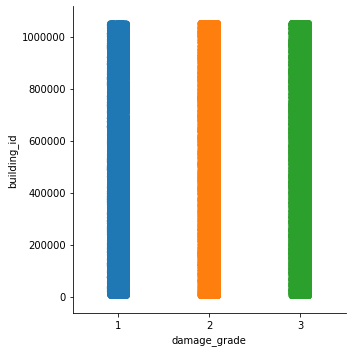

In [16]:
sns.catplot(x="damage_grade", y="building_id", data=train_target);

## Linear model

In [ ]:
estimator = LogisticRegression(random_state=0, solver='lbfgs',
...                          multi_class='multinomial')

In [77]:
# size increase by 7 times when convert number to string 

In [80]:
cross_val_score(estimator=estimator,X = X_train, y=y_train, scoring=scorer, cv=3)

array([0.56890915, 0.56890915, 0.56891729])

In [81]:
# Pretty much useless

In [88]:
cross_val_score(estimator=estimator,X = X_train[['count_floors_pre_eq','age']], y=y_train, scoring=scorer, cv=3)

array([0.56831054, 0.56859833, 0.56833017])

## Random Forest

In [139]:
def create_X(df):
    X = df.copy()
    cat_cols = X.columns[X.dtypes == 'object']
    num_cols = [i for i in X.columns if i not in cat_cols]
    
    x1 = X[cat_cols].apply(LabelEncoder().fit_transform)
    X = pd.concat([X[num_cols], x1], axis=1)
    
    return X
    

In [13]:
estimator = RandomForestClassifier(n_estimators=50,min_samples_leaf=1, n_jobs=-1)

In [12]:
cross_val_score(estimator=estimator,X=X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.71525763, 0.71781323, 0.71927704])

In [16]:
np.mean(np.array([0.71525763, 0.71781323, 0.71927704]))

0.7174493000000001

`estimator = RandomForestClassifier(n_estimators=10,min_samples_leaf=1)`  array([0.69160105, 0.69367316, 0.69515916])

`estimator = RandomForestClassifier(n_estimators=50,min_samples_leaf=1, n_jobs=-1)`  array([0.71525763, 0.71781323, 0.71927704])

` RandomForestClassifier(n_estimators=30,min_samples_leaf=1) ` [0.71034213, 0.71319703, 0.71529385] 

` random on one-hot encoding `
array([0.65804439, 0.65726159, 0.6648017 ])

In [106]:
from sklearn.model_selection import train_test_split
from rfpimp import *

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [108]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208480, 42), (52121, 42), (208480,), (52121,))

In [109]:
model = RandomForestClassifier(n_estimators=30, min_samples_leaf=3, n_jobs=-1)

In [110]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

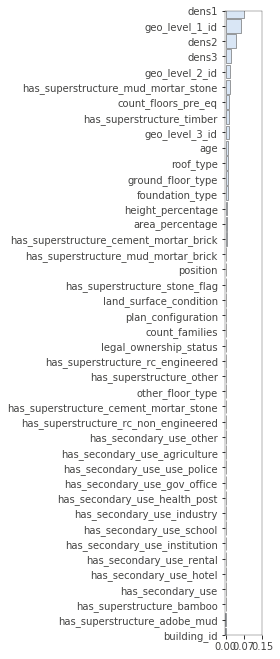

In [113]:
imp = importances(model, X_test, y_test) # permutation
viz = plot_importances(imp)

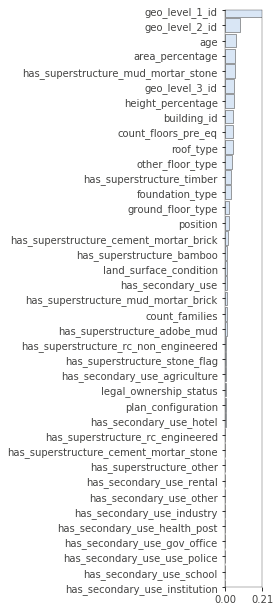

In [26]:
imp = importances(model, X_train, y_train) # permutation
viz = plot_importances(imp)

In [116]:
top20_features = imp.index[:20]

In [117]:
# use only top 10 features

In [119]:
cross_val_score(estimator=model,X = pd.concat([X_train, X_test])[top20_features], y=pd.concat([y_train, y_test]), scoring=scorer, cv=3,n_jobs=-1)

array([0.74003085, 0.74097481, 0.73847925])

In [134]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [135]:
cross_val_score(estimator=model,X = pd.concat([X_train, X_test])[top20_features], y=pd.concat([y_train, y_test]), scoring=scorer, cv=3,n_jobs=-1)

array([0.74426716, 0.74419809, 0.74108099])

In [133]:
np.array([0.74245982, 0.74248285, 0.7376734 ]).mean()

0.7408720233333334

In [54]:
# <70 for top 10 features
# 72.2 for top 20 features
# 72.2 for top 30 features


In [55]:
# are there any better ways to represent features.

In [56]:
imp.index[:10]

Index(['geo_level_1_id', 'geo_level_2_id',
       'has_superstructure_mud_mortar_stone', 'count_floors_pre_eq',
       'roof_type', 'height_percentage', 'has_superstructure_timber',
       'geo_level_3_id', 'other_floor_type', 'age'],
      dtype='object', name='Feature')

In [14]:
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [15]:
geo =  X[geo_features]

In [47]:
frame = pd.concat([geo,pd.DataFrame(y)],axis=1)

In [54]:
import matplotlib.pyplot as plt

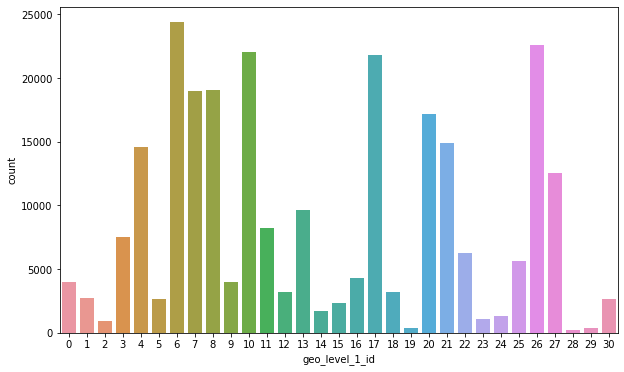

In [77]:
plt.figure(figsize=(10,6))
_ = sns.countplot(x='geo_level_1_id', data=frame)

In [87]:
x = true_test.groupby('geo_level_3_id',as_index=False)['building_id'].count()
x.sort_values('building_id',ascending=False,inplace=True)
x = x.iloc[:50]


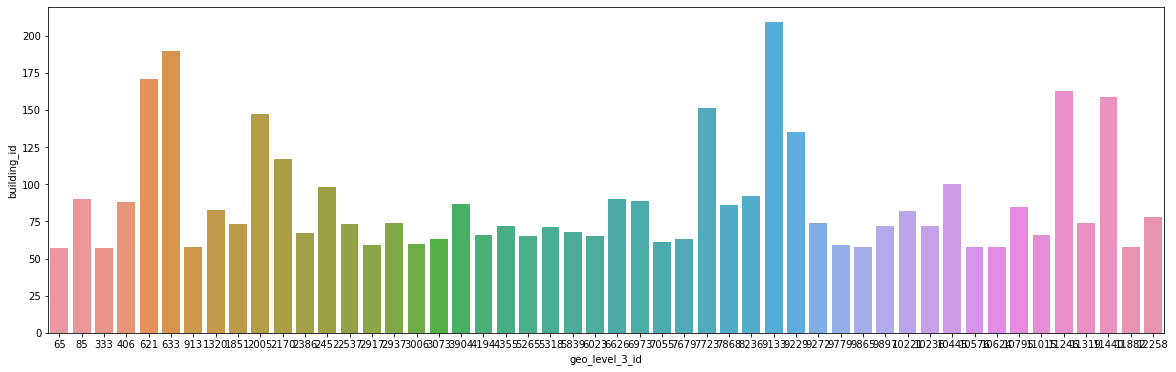

In [88]:
plt.figure(figsize=(20,6))
_ = sns.barplot(x='geo_level_3_id', y='building_id', data=x)

In [89]:
x = X.groupby('geo_level_3_id',as_index=False)['building_id'].count()
x.sort_values('building_id',ascending=False,inplace=True)

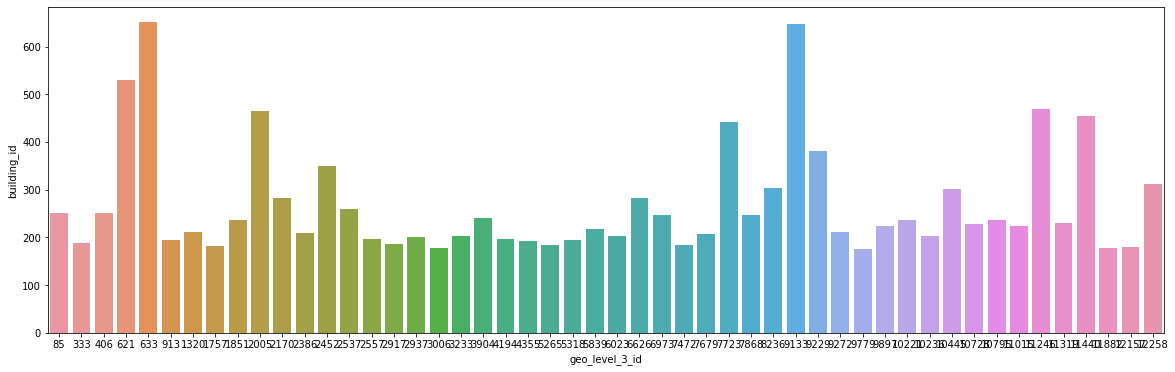

In [90]:
x = x.iloc[:50]


plt.figure(figsize=(20,6))
_ = sns.barplot(x='geo_level_3_id', y='building_id', data=x)

In [91]:
# all the 3 geo locations seem to be consistent within in train and test sets

In [94]:
col = X.geo_level_1_id

In [226]:
def create_density(train_col, test_col):
    d = dict(train_col.value_counts())
    return train_col.apply(lambda x: d[x]), test_col.apply(lambda x: d[x])

In [144]:
from collections import defaultdict

In [229]:
def create_density_test(test_col, col):
    d = dict(col.value_counts())
    mode_val = col.apply(lambda x: d[x]).mode()
    print(mode_val)
    test_d = defaultdict(lambda : mode_val)
    test_d.update(d)
    return col.apply(lambda x: test_d[x])

In [197]:
def new_rows(l1, l2):
    s = set(l2) - set(l1)
    return len([i for i in l2 if i in s])

In [286]:
true_test = pd.read_csv('../input/test_values.csv')

In [287]:
true_test = create_X(true_test)

In [288]:
from scipy import stats

In [289]:
def replace_new_values(l1, l2):
    mode = stats.mode(l1)[0][0]
#     print(mode)
    out = []
    for i in l2:
        if i not in l1:
#             print(i)
            out.append(mode)
        else:
            out.append(i)
    return out

In [290]:
true_test.geo_level_1_id = replace_new_values(X.geo_level_1_id.tolist(), true_test.geo_level_1_id.tolist())
true_test.geo_level_2_id = replace_new_values(X.geo_level_2_id.tolist(), true_test.geo_level_2_id.tolist())
true_test.geo_level_3_id = replace_new_values(X.geo_level_3_id.tolist(), true_test.geo_level_3_id.tolist())

In [293]:
X['dens1'], true_test['dens1'] = create_density(X.geo_level_1_id, true_test.geo_level_1_id)
X['dens2'], true_test['dens2'] = create_density(X.geo_level_2_id, true_test.geo_level_2_id)
X['dens3'], true_test['dens3'] = create_density(X.geo_level_3_id, true_test.geo_level_3_id)

In [294]:
model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, n_jobs=-1)

In [214]:
cross_val_score(estimator=model,X = X, y=y, scoring=scorer, cv=3,n_jobs=-1)

array([0.74092877, 0.74099784, 0.74085075])

In [296]:
model.fit(X[top20_features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [298]:
preds = model.predict(true_test[top20_features])

In [303]:
Counter(preds)

Counter({3: 24210, 2: 56831, 1: 5827, 'normalize': 1})

In [301]:
Counter(y)

Counter({3: 87218, 2: 148259, 1: 25124})

In [304]:
give_sub_file(preds, true_test.building_id.tolist(), path='../output/mode_values.csv')

Index(['building_id', 'damage_grade'], dtype='object')
(86868, 2)


## XGBOOST

In [16]:
from xgboost import XGBClassifier

In [17]:
xgb = XGBClassifier(n_estimators=30,subsample=0.3)

In [18]:
cross_val_score(estimator=xgb,X = X_train, y=y_train, scoring=scorer, cv=3,n_jobs=-1)

array([0.64708523, 0.64614127, 0.64909918])